# Setup

In [8]:
# Imports
from datasets import load_dataset
from transformers import (
    AutoModelForSequenceClassification,
    BertTokenizer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    TrainingArguments,
    Trainer,
)
import evaluate
import numpy as np
import torch

In [9]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("CUDA device name:", torch.cuda.get_device_name(0))

Using device: cuda
CUDA device name: NVIDIA GeForce RTX 4060


## Load Dataset

In [10]:
dataset = load_dataset("stanfordnlp/imdb")

train_validation_dataset = dataset["train"].train_test_split(test_size=0.1, seed=42)
train_dataset = train_validation_dataset["train"]
validation_dataset = train_validation_dataset["test"]
test_dataset = dataset["test"]          

print("Train size:", len(train_dataset))
print("Validation size:", len(validation_dataset))
print("Test size:", len(test_dataset))

Train size: 22500
Validation size: 2500
Test size: 25000


## Preprocessing of the dataset

In [11]:
def encode_datasets(tokenizer):
    def preprocess_datasets(examples):
        return tokenizer(
            examples["text"],
            truncation=True,
            max_length=512,
            padding="longest"
        )
    encoded_train = train_dataset.map(preprocess_datasets, batched=True)
    encoded_validation = validation_dataset.map(preprocess_datasets, batched=True)
    encoded_test = test_dataset.map(preprocess_datasets, batched=True)
    
    encoded_train = encoded_train.remove_columns(["text"])
    encoded_validation = encoded_validation.remove_columns(["text"])
    encoded_test = encoded_test.remove_columns(["text"])
    
    encoded_train = encoded_train.with_format("torch")
    encoded_validation = encoded_validation.with_format("torch")
    encoded_test = encoded_test.with_format("torch")
    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    return encoded_train, encoded_validation, encoded_test, data_collator
    

## Evaluation metrics

In [12]:
# Metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}


In [13]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"],
        "precision": precision.compute(predictions=preds, references=labels)["precision"],
        "recall": recall.compute(predictions=preds, references=labels)["recall"]
    }

# Train and test

## Train

In [14]:
def train_and_test_model(model_name):
    tokenizer = BertTokenizer.from_pretrained(
        model_name
    )
    encoded_train, encoded_validation, encoded_test, data_collator = encode_datasets(tokenizer)
    training_args = TrainingArguments(
        output_dir=f"./{model_name}_output",
        eval_strategy="epoch",  
        save_strategy="epoch",           
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        num_train_epochs=10,
        weight_decay=0.01,
        logging_steps=100,
        logging_first_step=True,
        load_best_model_at_end=True,
        report_to="none"
    )
    
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        id2label=id2label,
        label2id=label2id,
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=encoded_train, 
        eval_dataset=encoded_validation,
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,  
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )
    trainer.train()
    trainer.save_model(f"{model_name}_model")
    test_results = trainer.evaluate(encoded_test)
    
    print("\n====================")
    print(f"Test Results for {model_name}")
    print("====================")
    for k, v in test_results.items():
        print(f"{k}: {v}")
        
    return trainer, encoded_train, encoded_validation, encoded_test, data_collator

In [15]:
# Model names
model_name_uncased = "bert-base-uncased"
model_name_cased = "bert-base-cased"

In [9]:
train_and_test_model(model_name_cased)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.282900,0.287729,0.917200,0.917153,0.900763,0.938743
2,0.184200,0.296069,0.925600,0.925596,0.935012,0.915672
3,0.128100,0.451494,0.920400,0.920369,0.940833,0.898170



Test Results for bert-base-cased
eval_loss: 0.26278409361839294
eval_accuracy: 0.92076
eval_f1: 0.9206868947632355
eval_precision: 0.8966739573120145
eval_recall: 0.95112
eval_runtime: 693.2502
eval_samples_per_second: 36.062
eval_steps_per_second: 2.255
epoch: 3.0


In [11]:
train_and_test_model(model_name_uncased)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.264600,0.311718,0.910400,0.910176,0.959111,0.858393
2,0.201400,0.311861,0.932000,0.931999,0.930325,0.934765
3,0.083000,0.409590,0.929200,0.929200,0.934084,0.924423



Test Results for bert-base-uncased
eval_loss: 0.2569732964038849
eval_accuracy: 0.92624
eval_f1: 0.9261274091886965
eval_precision: 0.9623394654633808
eval_recall: 0.8872
eval_runtime: 396.3148
eval_samples_per_second: 63.081
eval_steps_per_second: 3.944
epoch: 3.0


## Visualize Testing

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

label_names = ["Negative", "Positive"]

def make_confusion_matrix(trainer, model_name, encoded_test_set):
    pred_output = trainer.predict(encoded_test_set)
    y_true = pred_output.label_ids
    y_pred = np.argmax(pred_output.predictions, axis=1)
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=label_names,
        yticklabels=label_names
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"Confusion Matrix – {model_name}")
    plt.tight_layout()
    plt.show()

In [19]:
def load_trainer_from_pretrained(model_name):
    tokenizer = BertTokenizer.from_pretrained(f"{model_name}_model")
    model = AutoModelForSequenceClassification.from_pretrained(f"{model_name}_model")
    
    encoded_train, encoded_validation, encoded_test, data_collator = encode_datasets(tokenizer)
    
    trainer = Trainer(
        model=model,
        processing_class=tokenizer,
        data_collator=data_collator
    )
    return trainer, encoded_train, encoded_validation, encoded_test, data_collator

In [20]:
(trainer_cased, 
 encoded_train_cased, 
 encoded_validation_cased, 
 encoded_test_cased, 
 data_collator_cased
 ) = load_trainer_from_pretrained(model_name_cased)

(trainer_uncased, 
 encoded_train_uncased, 
 encoded_validation_uncased, 
 encoded_test_uncased, 
 data_collator_uncased
 ) = load_trainer_from_pretrained(model_name_uncased)


wandb: Currently logged in as: rasmus-herskind96 (rasmus-herskind96-it-universitetet-i-k-benhavn). Use `wandb login --relogin` to force relogin
wandb: WARNING Unable to render Widget, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core


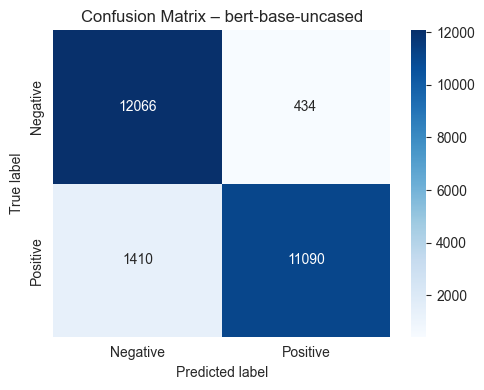

In [22]:
make_confusion_matrix(trainer_uncased, model_name_uncased, encoded_test_uncased)

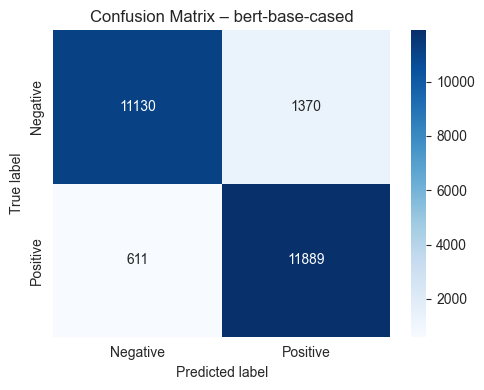

In [24]:
make_confusion_matrix(trainer_cased, model_name_cased, encoded_test_cased)

### Visualisation of worst performing datapoints

In [43]:
import torch
import torch.nn.functional as F

def predict_val_for_trainer(trainer, encoded_dataset_to_check):
    val_outputs = trainer.predict(encoded_dataset_to_check)

    logits = torch.tensor(val_outputs.predictions)
    labels = torch.tensor(val_outputs.label_ids)

    per_sample_loss = F.cross_entropy(logits, labels, reduction="none")

    return {
        "losses": per_sample_loss.detach().cpu().numpy(),
        "logits": logits.detach().cpu().numpy(),
        "labels": labels.detach().cpu().numpy(),
    }


def visualise_worst_performing(pred_info, dataset, top_k=20):
    losses = pred_info["losses"]
    logits = pred_info["logits"]
    labels = pred_info["labels"]

    # Sort by worst loss
    worst_idx = np.argsort(-losses)[:top_k]

    for i in worst_idx:
        true_label_id = int(labels[i])
        pred_label_id = int(np.argmax(logits[i]))

        print("INDEX:", i)
        print("True Label:", true_label_id)
        print("Predicted Label:", pred_label_id)
        print("Loss:", losses[i])
        print("Text:", dataset[int(i)]["text"])
        print("-" * 80)


In [38]:
val_loss_per_example_cased = predict_val_for_trainer(trainer_cased, encoded_validation_cased)
val_loss_per_example_uncased = predict_val_for_trainer(trainer_uncased, encoded_validation_uncased)

In [44]:
visualise_worst_performing(
    val_loss_per_example_cased,
    validation_dataset,
    top_k=20
)

INDEX: 287
True Label: 1
Predicted Label: 0
Loss: 6.033547
Text: I was really excited about seeing this film. I thought finally Australia had made a good film.. but I was wrong.<br /><br />This was the most pathetic attempt at a slasher film ever. I feel sorry for Molly Ringwald having to come all the way to Australia to make an awful movie.<br /><br />The acting was terrible (especially that Australian guy who was trying to speak in an American accent), and the plot was also pretty bad.<br /><br />When I first heard about this film coming out, I thought that the title was pathetic (because it sounds like the cheesy film "Stab" in Scream 2), but I was willing to let it slide if it was a good movie.<br /><br />WARNING!!! MAJOR SPOILERS!!!<br /><br />Probably the worst thing about the film was the ending. I was expecting a big surprise about who the killer was.. but the killer wasn't even human.. which turned this realistic slasher film into an awful horror movie.<br /><br />Don't see th

In [45]:
visualise_worst_performing(
    val_loss_per_example_uncased,
    validation_dataset,
    top_k=20
)

INDEX: 287
True Label: 1
Predicted Label: 0
Loss: 6.104041
Text: I was really excited about seeing this film. I thought finally Australia had made a good film.. but I was wrong.<br /><br />This was the most pathetic attempt at a slasher film ever. I feel sorry for Molly Ringwald having to come all the way to Australia to make an awful movie.<br /><br />The acting was terrible (especially that Australian guy who was trying to speak in an American accent), and the plot was also pretty bad.<br /><br />When I first heard about this film coming out, I thought that the title was pathetic (because it sounds like the cheesy film "Stab" in Scream 2), but I was willing to let it slide if it was a good movie.<br /><br />WARNING!!! MAJOR SPOILERS!!!<br /><br />Probably the worst thing about the film was the ending. I was expecting a big surprise about who the killer was.. but the killer wasn't even human.. which turned this realistic slasher film into an awful horror movie.<br /><br />Don't see th